{/* cspell:ignore fontsize */}

# AI Transpiler Introduction
*Estimated QPU usage: None (NOTE: no execution was done in this notebook as notebook is focused on the transpilation process)*

## Background

The **Qiskit AI-powered transpiler service (QTS)** introduces machine learning-based optimizations in both **routing** and **synthesis** passes. These AI modes have been designed to tackle the limitations of traditional transpilation, particularly for **large-scale circuits** and **complex hardware topologies**.

**Key Features of the AI-Powered Transpiler**:
- **Routing Passes**: AI-powered routing can dynamically adjust qubit paths based on the specific circuit and backend, reducing the need for excessive SWAP gates.
    - `AIRouting`: Layout selection and circuit routing

- **Synthesis Passes**: AI techniques optimize the decomposition of multi-qubit gates, minimizing the number of 2-qubit gates, which are typically more error-prone.
    - `AICliffordSynthesis`: Clifford gate synthesis
    - `AILinearFunctionSynthesis`: Linear function circuit synthesis
    - `AIPermutationSynthesis`: Permutation circuit synthesis
    - `AIPauliNetworkSynthesis`: Pauli Network circuit synthesis (only available in the Qiskit Transpiler Service, not in local environment)

**Comparison with Traditional Transpilation**: The standard Qiskit transpiler is a robust tool that can handle a broad spectrum of quantum circuits effectively. However, when circuits grow larger in scale or hardware configurations become more complex, the **Qiskit AI-powered transpiler service (QTS)** can deliver additional optimization gains. By leveraging **learned models** for routing and synthesis, QTS further refines circuit layouts and reduces overhead for challenging or large-scale quantum tasks.


In this tutorial, we will evaluate the AI modes using **both routing and synthesis** passes, comparing the results to traditional transpilation to highlight where AI offers performance gains.

For more information on the details of QTS, please refer to the [documentation](https://docs.quantum.ibm.com/guides/ai-transpiler-passes).


### Why Use AI for Quantum Circuit Transpilation?

As quantum circuits grow in size and complexity, traditional transpilation methods struggle to optimize layouts and reduce gate counts efficiently. Larger circuits, particularly those involving hundreds of qubits, impose significant challenges on routing and synthesis due to device constraints, limited connectivity, and qubit error rates.

This is where **AI-powered transpilation** offers a potential solution. By leveraging machine learning techniques, the AI-powered transpiler in Qiskit can make smarter decisions about **qubit routing** and **gate synthesis**, leading to better optimization of large-scale quantum circuits.

### Brief Benchmarking Results
![Graph showing AI transpiler performance against Qiskit](/images/tutorials/ai-transpiler-introduction/ai-transpiler-benchmarks.avif)


In benchmarking tests, the **Qiskit AI-powered transpiler service (QTS)** consistently produced **shallower, higher-quality circuits** compared to the standard Qiskit transpiler. For these tests, we used **Qiskit’s default pass manager strategy**—configured via the [`generate_preset_passmanager`](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset). While this default strategy is often effective, it can struggle with larger or more complex circuits. By contrast, QTS’s AI-powered passes achieved an **average 24% reduction** in 2-qubit gate counts and a **36% reduction** in circuit depth for large circuits (100+ qubits) when transpiling to the **heavy hex topology** of IBM Quantum hardware. For more information on these benchmarks, please refer to the following blog post [\[1\]](#references).

In this notebook, we will explore the **key benefits** of Qiskit AI-powered transpiler service and how it compares to traditional methods.

In [ ]:
# This cell is hidden from users;
# it just disables a linting rule.
# ruff: noqa: F811

## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later
* Qiskit IBM Transpiler (`pip install qiskit-ibm-transpiler`)
* Qiskit IBM AI Local Transpiler (`pip install qiskit_ibm_ai_local_transpiler`)

## Setup

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, QuantumVolume, QFT
from qiskit.transpiler import PassManager
from qiskit.circuit.random import random_circuit, random_clifford_circuit
from qiskit.transpiler import generate_preset_pass_manager, CouplingMap
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
from qiskit_ibm_transpiler.ai.collection import CollectPermutations
from qiskit_ibm_transpiler.ai.synthesis import AIPermutationSynthesis
from qiskit.circuit.library import Permutation
from qiskit.synthesis.permutation import (
    synth_permutation_acg,
    synth_permutation_depth_lnn_kms,
    synth_permutation_basic,
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time


# Used for generating permutation circuits in part 2 for comparison
def generate_permutation_circuit(width, pattern):
    circuit = QuantumCircuit(width)
    circuit.append(
        Permutation(num_qubits=width, pattern=pattern),
        qargs=range(width),
    )
    return circuit


def analyze_transpilation(
    results, circuit, pattern, pattern_id, coupling_map
):
    # AI Pass Manager
    pm_ai = PassManager(
        [
            CollectPermutations(
                do_commutative_analysis=True, max_block_size=27
            ),
            AIPermutationSynthesis(coupling_map=coupling_map),
        ]
    )
    start = time.time()
    qc_ai = pm_ai.run(circuit).decompose(reps=3)
    ai_time = time.time() - start
    results.append(
        {
            "Pattern": pattern_id,
            "Method": "AI",
            "Depth": qc_ai.depth(),
            "Gates(2q)": qc_ai.size(),
            "Time (s)": ai_time,
        }
    )

    # Non-AI Pass Manager
    pm_no_ai = generate_preset_pass_manager(
        coupling_map=coupling_map, optimization_level=1
    )

    # ACG Method
    qc_acg = synth_permutation_acg(pattern)
    start = time.time()
    qc_acg = pm_no_ai.run(qc_acg).decompose(reps=3)
    acg_time = time.time() - start
    results.append(
        {
            "Pattern": pattern_id,
            "Method": "ACG",
            "Depth": qc_acg.depth(),
            "Gates(2q)": qc_acg.size(),
            "Time (s)": acg_time,
        }
    )

    # Depth-LNN-KMS Method
    qc_depth_lnn_kms = synth_permutation_depth_lnn_kms(pattern)
    start = time.time()
    qc_depth_lnn_kms = pm_no_ai.run(qc_depth_lnn_kms).decompose(reps=3)
    depth_lnn_time = time.time() - start
    results.append(
        {
            "Pattern": pattern_id,
            "Method": "Depth-LNN-KMS",
            "Depth": qc_depth_lnn_kms.depth(),
            "Gates(2q)": qc_depth_lnn_kms.size(),
            "Time (s)": depth_lnn_time,
        }
    )

    # Basic Method
    qc_basic = synth_permutation_basic(pattern)
    start = time.time()
    qc_basic = pm_no_ai.run(qc_basic).decompose(reps=3)
    basic_time = time.time() - start
    results.append(
        {
            "Pattern": pattern_id,
            "Method": "Basic",
            "Depth": qc_basic.depth(),
            "Gates(2q)": qc_basic.size(),
            "Time (s)": basic_time,
        }
    )


# Used for benchmarking the circuits in part 3 for comparison
def run_transpilation(qc, no_ai_service, ai_service):
    # Standard transpilation
    time_start = time.time()
    qc_tr_no_ai = no_ai_service.run(qc)
    time_end = time.time()

    time_no_ai = time_end - time_start
    depth_no_ai = qc_tr_no_ai.depth(lambda x: x.operation.num_qubits == 2)
    gate_count_no_ai = qc_tr_no_ai.size()

    # AI transpilation
    time_start = time.time()
    qc_tr_ai = ai_service.run(qc)
    time_end = time.time()

    time_ai = time_end - time_start
    depth_ai = qc_tr_ai.depth(lambda x: x.operation.num_qubits == 2)
    gate_count_ai = qc_tr_ai.size()

    return {
        "depth_no_ai": depth_no_ai,
        "gate_count_no_ai": gate_count_no_ai,
        "time_no_ai": time_no_ai,
        "depth_ai": depth_ai,
        "gate_count_ai": gate_count_ai,
        "time_ai": time_ai,
    }


# Creates a Bernstein-Vazirani circuit given the number of qubits
def create_bv_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits - 1)
    qc.x(num_qubits - 1)
    qc.h(qc.qubits)
    for i in range(num_qubits - 1):
        qc.cx(i, num_qubits - 1)
    qc.h(qc.qubits[:-1])
    return qc

# Part I. Qiskit Patterns

Let's now see how to use the **AI transpiler service** with a simple quantum circuit and using Qiskit patterns. The key is creating a **TranspilerService instance** and specifying the use of AI modes during transpilation.

## Step 1: Map classical inputs to a quantum problem

In this section, we will test the AI transpiler on the `EfficientSU2` circuit, a widely used hardware-efficient ansatz. This circuit is particularly relevant for variational quantum algorithms (e.g., VQE) and quantum machine learning tasks, making it an ideal test case for assessing transpilation performance.

The `EfficientSU2` circuit consists of alternating layers of single-qubit rotations and entangling gates like CNOTs. These layers enable flexible exploration of the quantum state space while keeping the gate depth manageable, which is crucial for NISQ devices. By optimizing this circuit, we aim to reduce gate count, improve fidelity, and minimize noise. This makes it a strong candidate for testing the AI transpiler’s efficiency.

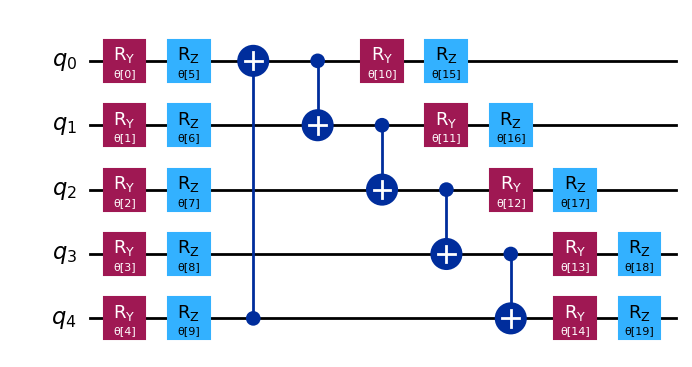

In [2]:
# For our transpilation, we will use a large circuit of 101 qubits
qc = EfficientSU2(101, entanglement="circular", reps=1).decompose()

# Draw a smaller version of the circuit to get a visual representation
qc_small = EfficientSU2(5, entanglement="circular", reps=1).decompose()
qc_small.draw(output="mpl")

## Step 2: Optimize problem for quantum hardware execution

**Choose a backend**

For this example, we will use the `ibm_brisbane` backend. This backend features a heavy hexagonal topology with 127 qubits, making it a suitable target for large-scale circuit demonstrations, especially when assessing performance on modern quantum hardware.

**Create TranspilerService Instances**

To evaluate the effectiveness of the AI transpiler, we will perform two transpilation runs. First, we will transpile the circuit using the AI transpiler. Then, we will run a comparison by transpiling the same circuit without the AI transpiler, using traditional methods. Both transpilation processes will use the following configuration:

`backend_name="ibm_brisbane"`

`optimization_level=3`

By comparing the results from these two runs, we will be able to assess how much optimization is gained by using the AI transpiler in terms of circuit depth, gate count, and runtime efficiency.

Notes:
- For best results, user can use `ai=auto` as it will run both the standard Qiskit heuristic passes and the AI-powered passes and return the best result. For our example, we will run the AI-powered passes explicitly to show the difference in results.

- Similar to `generate_preset_passmanager`, the `generate_ai_passmanager` function can be used for a hybrid AI-powered transpilation, example usage shown below.

```python
    from qiskit.circuit.library import EfficientSU2
    from qiskit_ibm_transpiler import generate_ai_pass_manager

    su2_circuit = EfficientSU2(101, entanglement="circular", reps=1).decompose()

    ai_transpiler_pass_manager = generate_ai_pass_manager(
        coupling_map=coupling_map,
        ai_optimization_level=ai_optimization_level,
        include_ai_synthesis=include_ai_synthesis,
        optimization_level=optimization_level,
        ai_layout_mode=ai_layout_mode,
        qiskit_transpile_options=qiskit_transpile_options,
    )
    transpiled_circuit = ai_transpiler_pass_manager.run(su2_circuit)
```

In [3]:
ai_service = TranspilerService(
    backend_name="ibm_brisbane",
    ai="true",
    optimization_level=3,
)

no_ai_service = TranspilerService(
    backend_name="ibm_brisbane",
    ai="false",
    optimization_level=3,
)

Transpile the circuits and record the times.

In [4]:
time_start = time.time()
qc_tr_no_ai = no_ai_service.run(qc)
time_end = time.time()
time_no_ai = time_end - time_start
print(f"Standard transpilation: {time_no_ai} seconds")

time_start = time.time()
qc_tr_ai = ai_service.run(qc)
time_end = time.time()
time_ai = time_end - time_start
print(f"AI transpilation      : {time_ai} seconds")

/Users/henryzou/.venvs/ibm-learning-sabre/lib/python3.11/site-packages/qiskit/qpy/interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.2.4, is newer than the current qiskit version 1.2.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


Standard transpilation: 43.817320108413696 seconds
AI transpilation      : 21.043448209762573 seconds


In [5]:
depth_no_ai = qc_tr_no_ai.depth(lambda x: x.operation.num_qubits == 2)
depth_ai = qc_tr_ai.depth(lambda x: x.operation.num_qubits == 2)

gate_count_no_ai = qc_tr_no_ai.size()
gate_count_ai = qc_tr_ai.size()

print(
    f"Standard transpilation: Depth {depth_no_ai}, Gate count {gate_count_no_ai}, Time {time_no_ai}"
)
print(
    f"AI transpilation      : Depth {depth_ai}, Gate count {gate_count_ai}, Time {time_ai}"
)

Standard transpilation: Depth 482, Gate count 4467, Time 43.817320108413696
AI transpilation      : Depth 131, Gate count 2358, Time 21.043448209762573


In this test, we compare the performance of the AI transpiler and the standard transpilation method on the EfficientSU2 circuit using the `ibm_brisbane` backend. The results show a significant improvement in the circuit's depth, gate count, and transpilation time when using the AI transpiler:

- **Circuit Depth**: This reduction in depth is substantial (over 50%), as it means the AI transpiler has found a more efficient arrangement of qubit interactions, which can directly impact the overall fidelity of the circuit on quantum hardware. A shallower circuit helps mitigate qubit decoherence and reduces the likelihood of noise affecting the outcome.

- **Gate Count**: The AI transpiler also reduced the gate count by nearly 50%. Since each gate has an associated error rate, fewer gates directly lower the overall chance of error, which is critical for maintaining coherence and improving the reliability of results in practical quantum computing tasks.


- **Transpilation Time Efficiency**: While the time varies for the device, the time it took to transpile the circuit was drastically reduced, over a 50% improvement. This shows that the AI-powered transpiler not only optimizes the resulting circuit but also improves the efficiency of the transpilation process itself, making it faster to generate optimized circuits.

It is important to note that these results are based on just one circuit. To obtain a comprehensive understanding of how the AI transpiler compares to traditional methods, it is necessary to test a variety of circuits. The performance of QTS can vary greatly depending on the type of circuit being optimized. For a broader comparison, refer to the benchmarks above or visit the following IBM Blog Post[\[1\]](#references)

## Step 3: Execute using Qiskit primitives
As this tutorial focuses on transpilation, no experiments will be executed on the quantum device. The goal is to leverage the optimizations from Step 2 to obtain a transpiled circuit with reduced depth and/or gate count.

## Step 4: Post-process and return result in desired classical format
Since there is no execution for this notebook, there are no results to post-process.

# Part II. Analyzing and benchmarking the transpiled circuits

In this section, we will demonstrate how to analyze the transpiled circuit and benchmark it against the original version in more detail. We will focus on metrics such as circuit depth, gate count, and transpilation time to assess the effectiveness of the optimization. Additionally, we will discuss how the results may differ across various circuit types, offering insights into the broader performance of the transpiler across different scenarios.

In [6]:
# Circuits to benchmark
seed = 42
circuits = [
    {
        "name": "Random",
        "qc": random_circuit(num_qubits=30, depth=10, seed=seed),
    },
    {
        "name": "Clifford",
        "qc": random_clifford_circuit(
            num_qubits=40, num_gates=200, seed=seed
        ),
    },
    {"name": "QFT", "qc": QFT(20, do_swaps=False).decompose()},
    {
        "name": "BV",
        "qc": create_bv_circuit(40),
    },  # Using the BV circuit function
    {"name": "QV", "qc": QuantumVolume(num_qubits=20, depth=10, seed=seed)},
]

results = []

# Run the transpilation for each circuit and store the results
for circuit in circuits:
    data = run_transpilation(circuit["qc"], no_ai_service, ai_service)
    print("Completed transpilation for", circuit["name"])
    results.append(
        {
            "Circuit": circuit["name"],
            "Depth (No AI)": data["depth_no_ai"],
            "Gate Count (No AI)": data["gate_count_no_ai"],
            "Time (No AI)": data["time_no_ai"],
            "Depth (AI)": data["depth_ai"],
            "Gate Count (AI)": data["gate_count_ai"],
            "Time (AI)": data["time_ai"],
        }
    )
df = pd.DataFrame(results)
print(df)

/Users/henryzou/.venvs/ibm-learning-sabre/lib/python3.11/site-packages/qiskit/qpy/interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.2.4, is newer than the current qiskit version 1.2.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


Completed transpilation for Random
Completed transpilation for Clifford
Completed transpilation for QFT
Completed transpilation for BV
Completed transpilation for QV
    Circuit  Depth (No AI)  Gate Count (No AI)  Time (No AI)  Depth (AI)  \
0    Random            345                7842      3.944334         298   
1  Clifford             84                2284      2.354044          67   
2       QFT            328                4847      3.657239         217   
3        BV            135                1116      2.536958         103   
4        QV            198                5075      2.670678         174   

   Gate Count (AI)  Time (AI)  
0             8738  34.042681  
1             2173  18.066975  
2             4602  25.296369  
3              791  21.240081  
4             5613  26.749141  


Average percentage reduction for each metric. Positive are improvements, negative are degradations.

In [7]:
# Average reduction from non-AI to AI transpilation as a percentage
avg_reduction_depth = (
    (df["Depth (No AI)"] - df["Depth (AI)"]).mean()
    / df["Depth (No AI)"].mean()
    * 100
)
avg_reduction_gates = (
    (df["Gate Count (No AI)"] - df["Gate Count (AI)"]).mean()
    / df["Gate Count (No AI)"].mean()
    * 100
)
avg_reduction_time = (
    (df["Time (No AI)"] - df["Time (AI)"]).mean()
    / df["Time (No AI)"].mean()
    * 100
)

print(f"Average reduction in depth: {avg_reduction_depth:.2f}%")
print(f"Average reduction in gate count: {avg_reduction_gates:.2f}%")
print(f"Average reduction in transpilation time: {avg_reduction_time:.2f}%")

Average reduction in depth: 21.19%
Average reduction in gate count: -3.56%
Average reduction in transpilation time: -726.97%


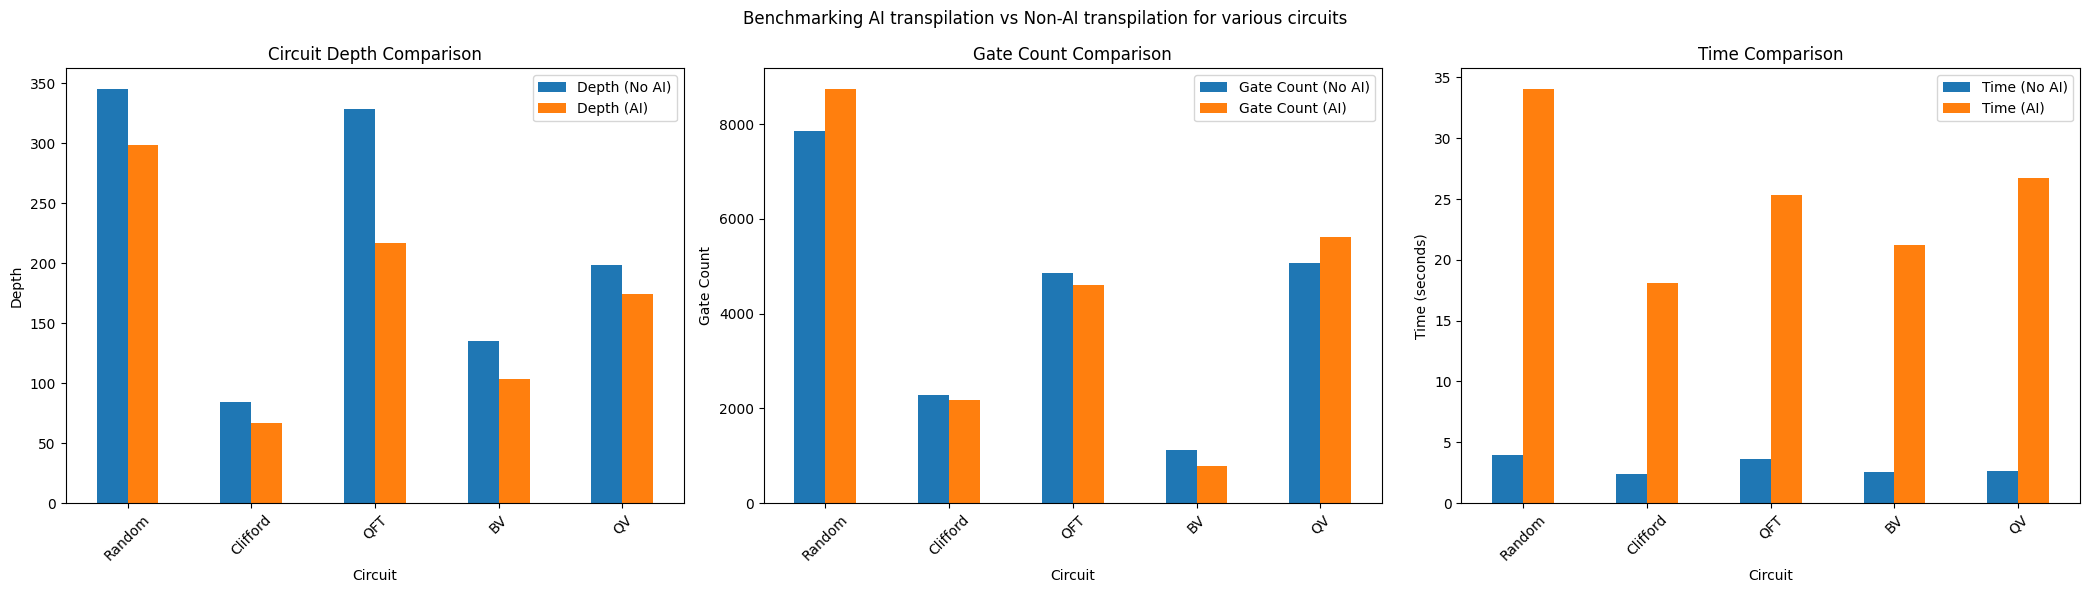

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
df.plot(x="Circuit", y=["Depth (No AI)", "Depth (AI)"], kind="bar", ax=axs[0])
axs[0].set_title("Circuit Depth Comparison")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Circuit")
axs[0].tick_params(axis="x", rotation=45)
df.plot(
    x="Circuit",
    y=["Gate Count (No AI)", "Gate Count (AI)"],
    kind="bar",
    ax=axs[1],
)
axs[1].set_title("Gate Count Comparison")
axs[1].set_ylabel("Gate Count")
axs[1].set_xlabel("Circuit")
axs[1].tick_params(axis="x", rotation=45)
df.plot(x="Circuit", y=["Time (No AI)", "Time (AI)"], kind="bar", ax=axs[2])
axs[2].set_title("Time Comparison")
axs[2].set_ylabel("Time (seconds)")
axs[2].set_xlabel("Circuit")
axs[2].tick_params(axis="x", rotation=45)
fig.suptitle(
    "Benchmarking AI transpilation vs Non-AI transpilation for various circuits"
)

plt.tight_layout()
plt.show()

The AI transpiler's performance varies significantly based on the type of circuit being optimized. In some cases, it achieves notable reductions in circuit depth and gate count compared to the standard transpiler. However, these improvements often come with a substantial increase in runtime.

For certain types of circuits, the AI transpiler may yield slightly better results in terms of circuit depth but may also lead to an increase in gate count and a significant runtime penalty. These observations suggest that the AI transpiler's benefits are not uniform across all circuit types. Instead, its effectiveness depends on the specific characteristics of the circuit, making it more suitable for some use cases than others.

## When should users choose AI-powered transpilation?

The AI-powered transpiler in Qiskit excels in scenarios where traditional transpilation methods struggle—particularly with large-scale and complex quantum circuits. For circuits involving hundreds of qubits or those targeting hardware with intricate coupling maps, the AI transpiler offers superior optimization in terms of circuit depth, gate count, and runtime efficiency. In benchmarking tests, it has consistently outperformed traditional methods, delivering significantly shallower circuits and reducing gate counts, which are critical for enhancing performance and mitigating noise on real quantum hardware.

Users should consider AI-powered transpilation when working with:
- Large circuits where traditional methods fail to efficiently handle the scale.
- Complex hardware topologies where device connectivity and routing challenges arise.
- Performance-sensitive applications where reducing circuit depth and improving fidelity are paramount.

#### Getting the Best Results: Using `ai="auto"`
For optimal results, users can set ai="auto" in the Qiskit Transpiler Service. This automatically selects the best AI-based optimizations based on the circuit and target hardware, ensuring that the transpiler delivers the highest performance without manual configuration. This mode is ideal for users who want the convenience of automatic optimization while still benefiting from the powerful AI-driven enhancements to circuit routing and synthesis.

# Part III. Exploring AI-powered permutation network synthesis

Permutation networks are foundational in quantum computing, particularly for systems constrained by restricted topologies. These networks facilitate long-range interactions by dynamically swapping qubits to mimic all-to-all connectivity on hardware with limited connectivity. Such transformations are essential for implementing complex quantum algorithms on near-term devices, where interactions often span beyond nearest neighbors.

In this section, we highlight the synthesis of permutation networks as a compelling use case for the AI-powered transpiler in Qiskit. Specifically, the `AIPermutationSynthesis` pass leverages AI-driven optimization to generate efficient circuits for qubit permutation tasks. By contrast, generic synthesis approaches often struggle to balance gate count and circuit depth, especially in scenarios with dense qubit interactions or when attempting to achieve full connectivity.

We will walk through a Qiskit patterns example showcasing the synthesis of a permutation network to achieve all-to-all connectivity for a set of qubits. We will compare the performance of `AIPermutationSynthesis` against the standard synthesis methods in Qiskit. This example will demonstrate how the AI transpiler optimizes for lower circuit depth and gate count, highlighting its advantages in practical quantum workflows.

For more details about the AI-powered permutation synthesis in QTS, please refer to the [Qiskit API documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-transpiler/qiskit_ibm_transpiler.ai.AIPermutationSynthesis).

## Step 1: Map classical inputs to a quantum problem

To represent a classical permutation problem on a quantum computer, we start by defining the structure of the quantum circuits. For this example:

1. **Quantum Circuit Initialization**:
   We allocate 27 qubits to match the backend we will use, which has 27 qubits.

2. **Applying Permutations**:
   We generate five random permutation patterns (`pattern_1` through `pattern_5`) using a fixed seed (42) for reproducibility. Each permutation pattern is applied to a separate quantum circuit (`qc_1` through `qc_5`).

3. **Circuit Decomposition**:
   Each permutation operation is decomposed into native gate sets compatible with the target quantum hardware. We analyze the depth and the number of two-qubit gates (nonlocal gates) for each decomposed circuit.

The results provide insight into the complexity of representing classical permutation problems on a quantum device, demonstrating the resource requirements for different permutation patterns.

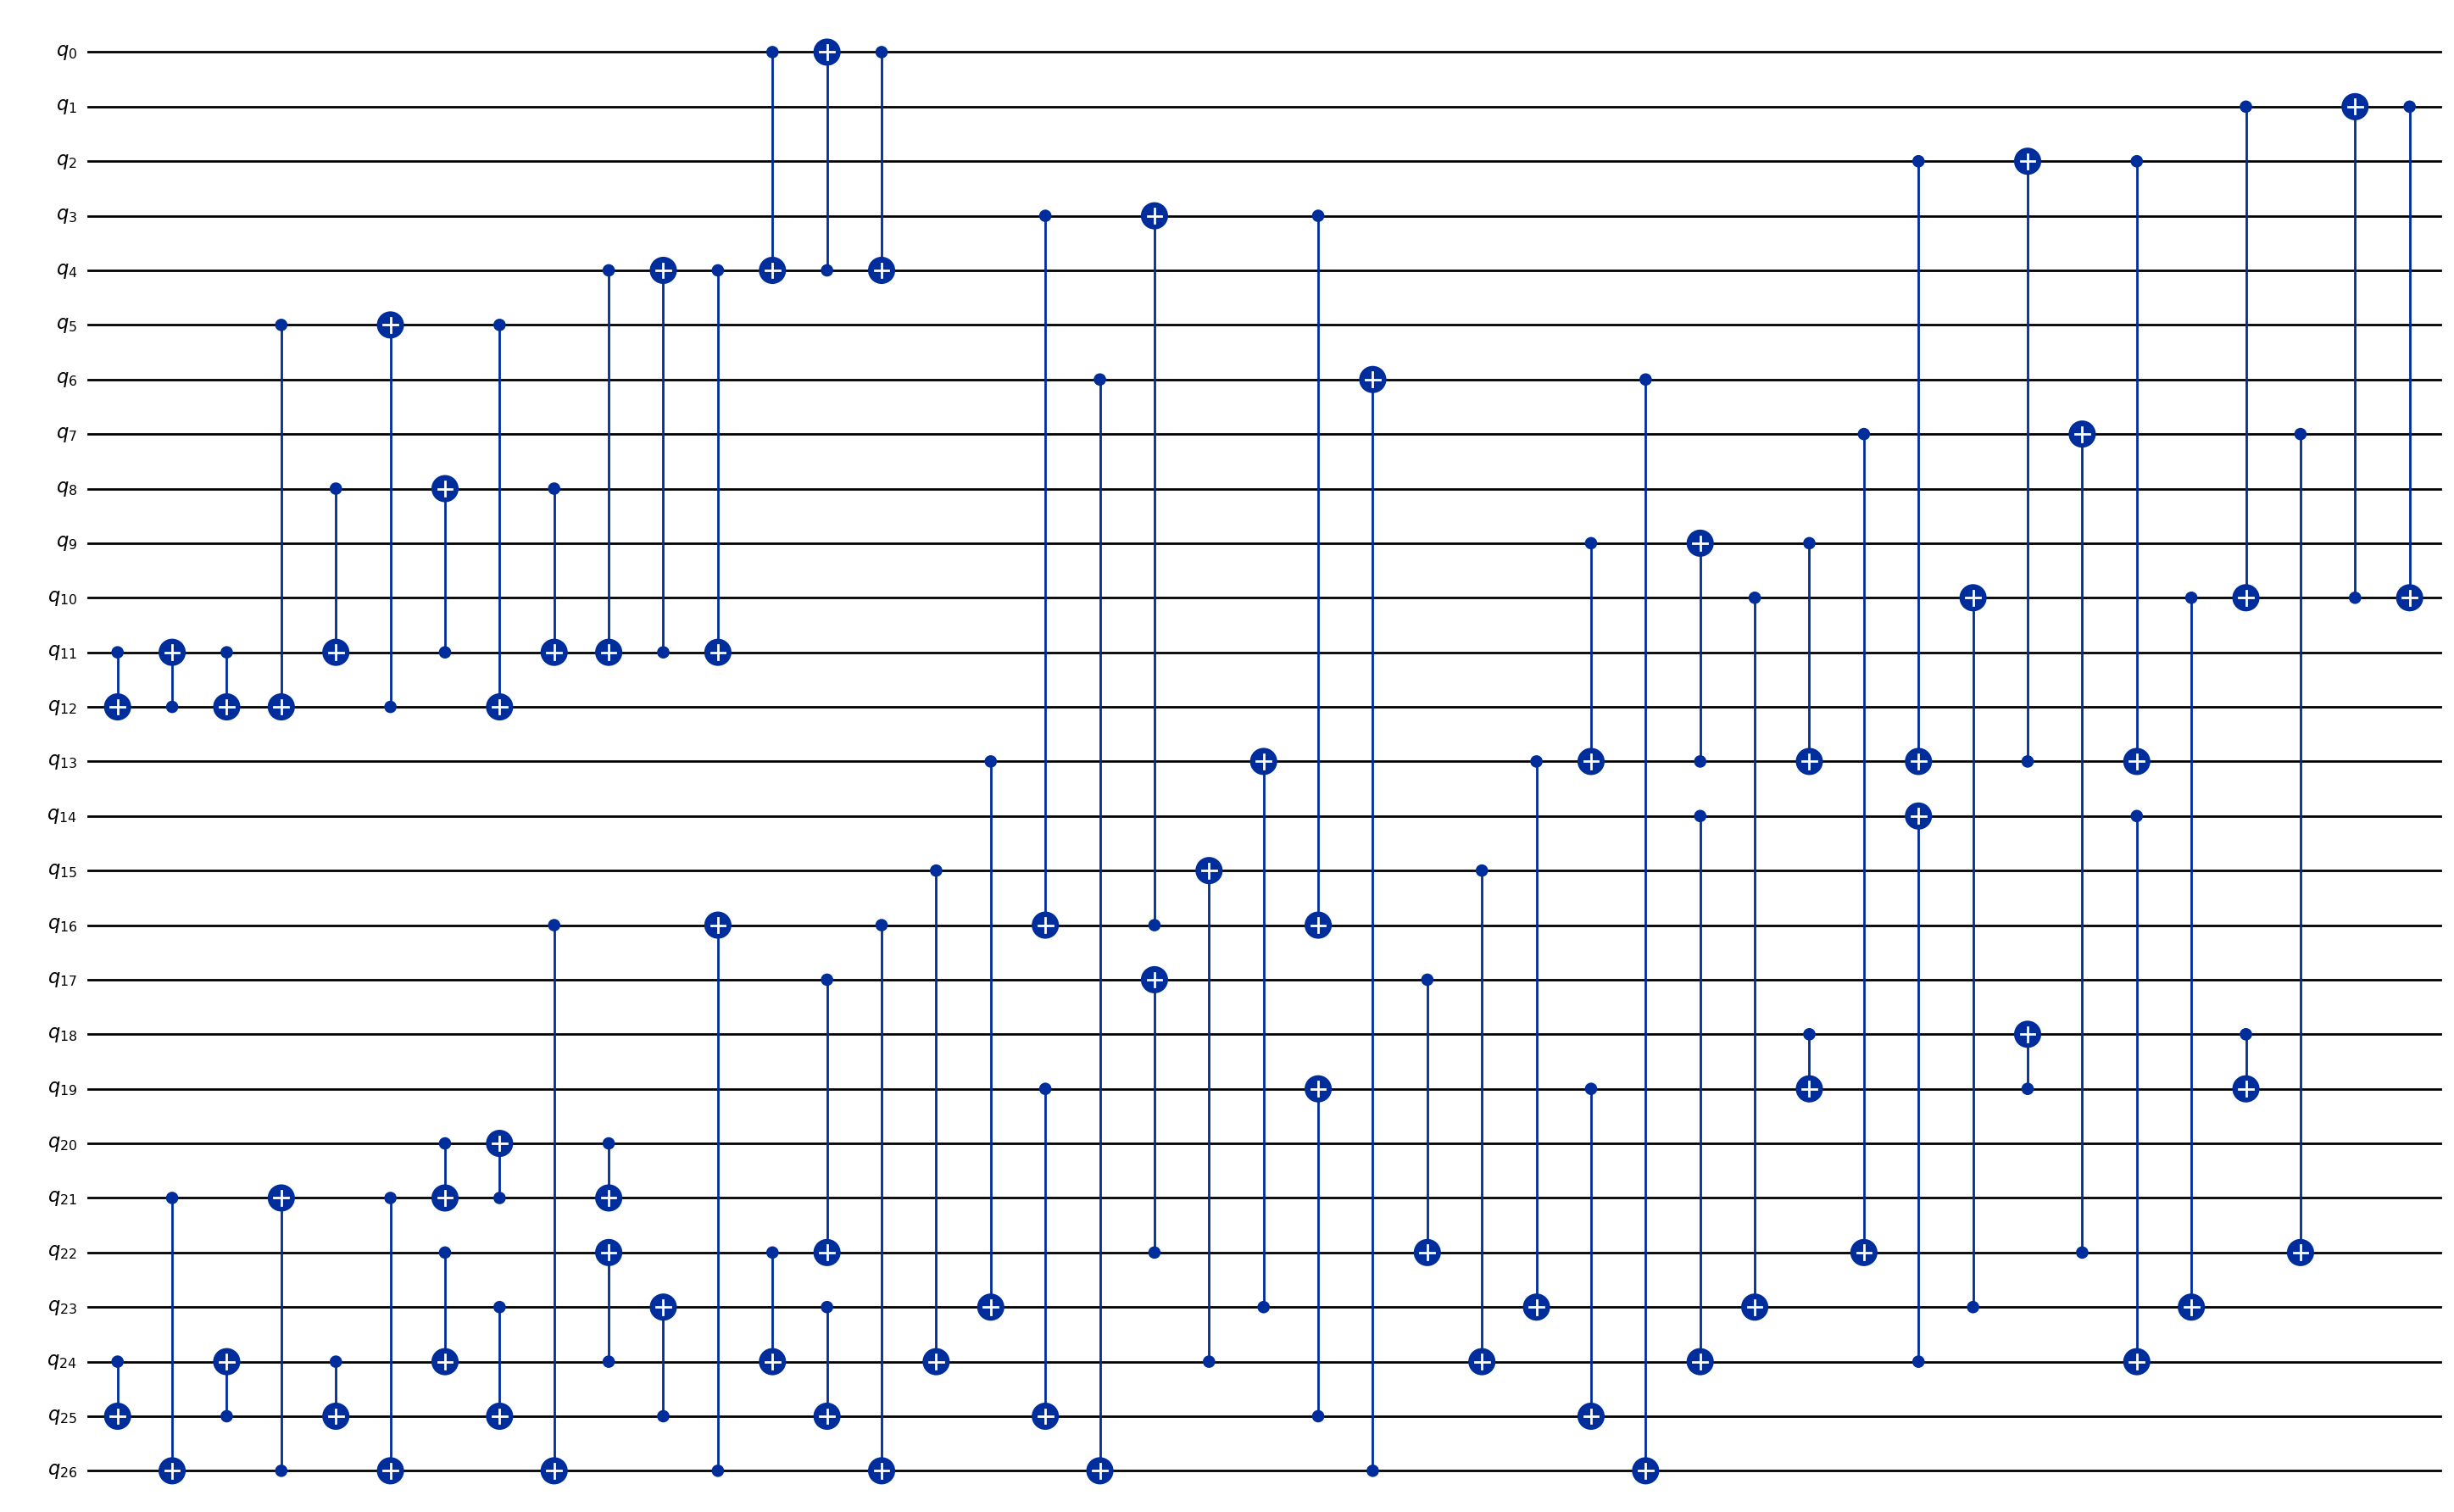

In [9]:
# Parameters
width = 27
num_circuits = 5
seed = 42

# Set random seed
np.random.seed(seed)


# Function to generate permutation circuit
def generate_permutation_circuit(width, pattern):
    circuit = QuantumCircuit(width)
    circuit.append(
        Permutation(num_qubits=width, pattern=pattern),
        qargs=range(width),
    )
    return circuit


# Generate random patterns and circuits
patterns = [
    np.random.permutation(width).tolist() for _ in range(num_circuits)
]
circuits = {
    f"qc_{i}": generate_permutation_circuit(width, pattern)
    for i, pattern in enumerate(patterns, start=1)
}

# Display one of the circuits
circuits["qc_1"].decompose(reps=3).draw(output="mpl", fold=-1)

## Step 2: Optimize problem for quantum hardware execution
In this step, we proceed with optimization using the AI synthesis passes.

For the AI synthesis passes, the `PassManager` requires only the coupling map of the backend. However, it is important to note that not all coupling maps are compatible; only those that the `AIPermutationSynthesis` pass has been trained on will work. Currently, the `AIPermutationSynthesis` pass supports blocks of sizes 65, 33, and 27 qubits. Thus we will select `ibm_cario` as the backend for this example, as it has 27 qubits.

For comparison, we will evaluate the performance of AI synthesis against generic permutation synthesis methods in Qiskit, including:

- **`synth_permutation_depth_lnn_kms`:** This method synthesizes a permutation circuit for a linear nearest-neighbor (LNN) architecture using the Kutin, Moulton, and Smithline (KMS) algorithm. It guarantees a circuit with a depth of at most $ n $ and a size of at most $ n(n-1)/2 $, where both depth and size are measured in terms of SWAP gates.

- **`synth_permutation_acg`:** This method synthesizes a permutation circuit for a fully-connected architecture using the Alon, Chung, and Graham (ACG) algorithm. It produces a circuit with a depth of exactly 2 (in terms of the number of SWAP gates).

- **`synth_permutation_basic`:** This is a straightforward implementation that synthesizes permutation circuits without imposing constraints on connectivity or optimization for specific architectures. It serves as a baseline for comparing performance with more advanced methods.

Each of these methods represents a distinct approach to synthesizing permutation networks, providing a comprehensive benchmark against the AI-powered methods.

For more details about synthesis methods in Qiskit, refer to the [Qiskit API documentation](https://docs.quantum.ibm.com/api/qiskit/synthesis).

Define the coupling map representing `ibm_cario`, a 27-qubit device.

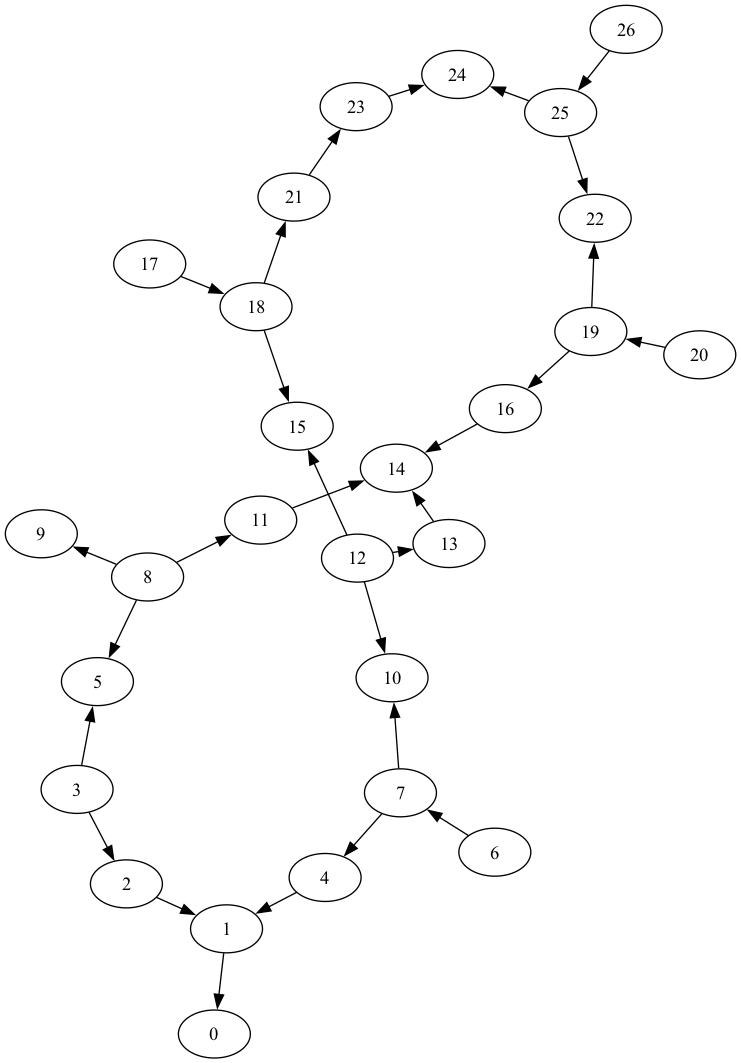

In [10]:
coupling_map = [
    [1, 0],
    [2, 1],
    [3, 2],
    [3, 5],
    [4, 1],
    [6, 7],
    [7, 4],
    [7, 10],
    [8, 5],
    [8, 9],
    [8, 11],
    [11, 14],
    [12, 10],
    [12, 13],
    [12, 15],
    [13, 14],
    [16, 14],
    [17, 18],
    [18, 15],
    [18, 21],
    [19, 16],
    [19, 22],
    [20, 19],
    [21, 23],
    [23, 24],
    [25, 22],
    [25, 24],
    [26, 25],
]
CouplingMap(coupling_map).draw()

Create the pass managers and transpile each of the permutation circuits using the AI synthesis passes and generic synthesis methods.

In [11]:
results = []

# Transpile and analyze all circuits
for i, (qc_name, circuit) in enumerate(circuits.items(), start=1):
    pattern = patterns[i - 1]
    analyze_transpilation(results, circuit, pattern, qc_name, coupling_map)
results_df = pd.DataFrame(results)

Record the metrics (depth, gate count, time) for each circuit after transpilation.

In [12]:
# Calculate averages for each metric
average_metrics = results_df.groupby("Method")[
    ["Depth", "Gates(2q)", "Time (s)"]
].mean()
average_metrics = average_metrics.round(2)  # Round to 2 decimal places
print("\n=== Average Metrics ===")
print(average_metrics)

# Identify the best non-AI method based on least average depth
non_ai_methods = [
    method for method in results_df["Method"].unique() if method != "AI"
]
best_non_ai_method = average_metrics.loc[non_ai_methods]["Depth"].idxmin()
print(
    f"\nBest Non-AI Method (based on least average depth): {best_non_ai_method}"
)

# Compare AI to the best non-AI method
ai_metrics = average_metrics.loc["AI"]
best_non_ai_metrics = average_metrics.loc[best_non_ai_method]

comparison = {
    "Metric": ["Depth", "Gates(2q)", "Time (s)"],
    "AI": [
        round(ai_metrics["Depth"], 2),
        round(ai_metrics["Gates(2q)"], 2),
        round(ai_metrics["Time (s)"], 2),
    ],
    best_non_ai_method: [
        round(best_non_ai_metrics["Depth"], 2),
        round(best_non_ai_metrics["Gates(2q)"], 2),
        round(best_non_ai_metrics["Time (s)"], 2),
    ],
    "Improvement (AI vs Best Non-AI)": [
        round(ai_metrics["Depth"] - best_non_ai_metrics["Depth"], 2),
        round(ai_metrics["Gates(2q)"] - best_non_ai_metrics["Gates(2q)"], 2),
        round(ai_metrics["Time (s)"] - best_non_ai_metrics["Time (s)"], 2),
    ],
}

comparison_df = pd.DataFrame(comparison)
print("\n=== Comparison of AI vs Best Non-AI Method ===")
print(comparison_df)


=== Average Metrics ===
               Depth  Gates(2q)  Time (s)
Method                                   
ACG             24.0      120.0      0.01
AI              21.0       71.4      0.00
Basic           33.6      108.0      0.00
Depth-LNN-KMS  138.0      623.4      0.02

Best Non-AI Method (based on least average depth): ACG

=== Comparison of AI vs Best Non-AI Method ===
      Metric    AI     ACG  Improvement (AI vs Best Non-AI)
0      Depth  21.0   24.00                            -3.00
1  Gates(2q)  71.4  120.00                           -48.60
2   Time (s)   0.0    0.01                            -0.01


The results demonstrate that the AI transpiler outperforms all other Qiskit synthesis methods for this set of random permutation circuits. Key findings include:

1. **Depth**: The AI transpiler achieves the lowest average depth, indicating superior optimization of circuit layouts.
2. **Gate Count**: It significantly reduces the number of two-qubit gates compared to other methods, improving execution fidelity and efficiency.
3. **Transpilation Time**: All methods, including the AI transpiler, run very quickly at this scale, making them practical for use. However, the AI transpiler provides additional optimization benefits without added runtime cost.

These results establish the AI transpiler as the most effective approach for this benchmark, particularly for depth and gate count optimization.

Plot the results to compare the performance of the AI synthesis passes against the generic synthesis methods.

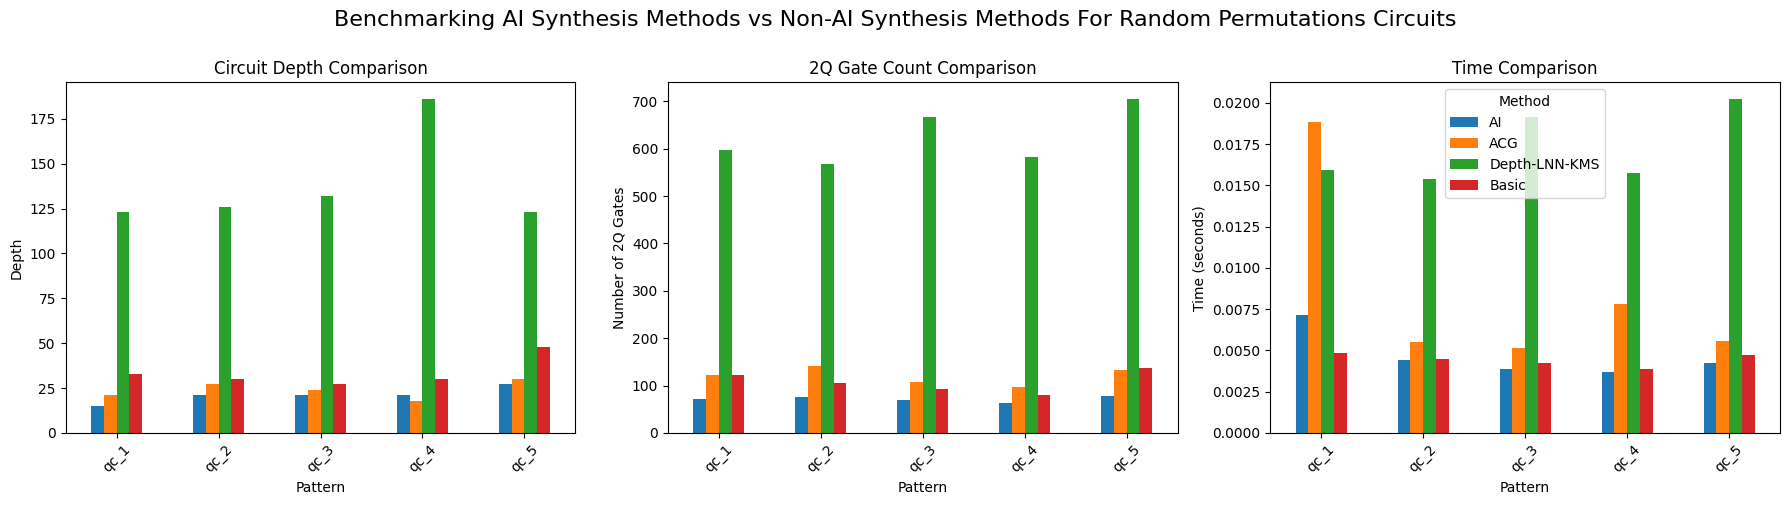

In [13]:
methods = results_df["Method"].unique()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Pivot the DataFrame and reorder columns to ensure AI is first
pivot_depth = results_df.pivot(
    index="Pattern", columns="Method", values="Depth"
)[["AI", "ACG", "Depth-LNN-KMS", "Basic"]]
pivot_gates = results_df.pivot(
    index="Pattern", columns="Method", values="Gates(2q)"
)[["AI", "ACG", "Depth-LNN-KMS", "Basic"]]
pivot_time = results_df.pivot(
    index="Pattern", columns="Method", values="Time (s)"
)[["AI", "ACG", "Depth-LNN-KMS", "Basic"]]

pivot_depth.plot(kind="bar", ax=axs[0], legend=False)
axs[0].set_title("Circuit Depth Comparison")
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Pattern")
axs[0].tick_params(axis="x", rotation=45)
pivot_gates.plot(kind="bar", ax=axs[1], legend=False)
axs[1].set_title("2Q Gate Count Comparison")
axs[1].set_ylabel("Number of 2Q Gates")
axs[1].set_xlabel("Pattern")
axs[1].tick_params(axis="x", rotation=45)
pivot_time.plot(
    kind="bar", ax=axs[2], legend=True, title="Legend"
)  # Show legend on the last plot
axs[2].set_title("Time Comparison")
axs[2].set_ylabel("Time (seconds)")
axs[2].set_xlabel("Pattern")
axs[2].tick_params(axis="x", rotation=45)
fig.suptitle(
    "Benchmarking AI Synthesis Methods vs Non-AI Synthesis Methods For Random Permutations Circuits",
    fontsize=16,
    y=1,
)

plt.tight_layout()
plt.show()

This graph highlights the individual results for each circuit (`qc_1` to `qc_5`) across different synthesis methods:

1. **Circuit Depth**:
   The AI transpiler often achieves **comparable or better depth optimizations** than other methods, highlighting its ability to optimize depth efficiently for these permutation circuits.

2. **2Q Gate Count**:
   The AI transpiler also shows a substantial reduction in the number of two-qubit gates compared to other methods, indicating more efficient resource usage and improved circuit quality.

3. **Transpilation Time**:
   All methods, including the AI transpiler, run quickly at this scale. However, the AI method achieves its optimizations without introducing additional runtime overhead, making it highly practical.

While these results underscore the AI transpiler’s effectiveness for permutation circuits, it is important to note its **limitations**. The AI synthesis method is currently only available for certain coupling maps, which may restrict its broader applicability. This constraint should be considered when evaluating its usage in different scenarios.

Overall, the AI transpiler **demonstrates promising improvements** in depth and gate count optimization for these specific circuits while maintaining comparable transpilation times.

## Step 3: Execute using Qiskit primitives
As this tutorial focuses on transpilation, no experiments will be executed on the quantum device. The goal is to leverage the optimizations from Step 2 to obtain a transpiled circuit with reduced depth and/or gate count.

## Step 4: Post-process and return result in desired classical format
Since there is no execution for this notebook, there are no results to post-process.

## Limitations of QTS

While the **Qiskit AI-powered Transpiler Service (QTS)** can offer significant performance benefits for large and complex quantum circuits, there are several service-level constraints and AI pass–specific considerations to be aware of.

- **Maximum 2Q Gates per Circuit**
  Each circuit can include up to **1 million two-qubit gates** in any AI mode.
- **Transpilation Run Time**
  Each transpilation process can run for up to **30 minutes**. If it exceeds this limit, the job will be canceled.
- **Retrieving Results**
  You must retrieve the transpilation result within **20 minutes** after the process finishes. After that, the result is discarded.
- **Job Queue Time**
  A set of circuits can remain in the internal queue for up to **120 minutes** while waiting to be transpiled. If the process doesn’t start within this window, the job is canceled.
- **Qubit Limit**
  Currently, there is no strictly defined maximum number of qubits. However, the service has been tested successfully with circuits of **900+ qubits**.

While QTS often delivers significant improvements in gate count and circuit depth, overall transpilation performance can vary based on circuit size, connectivity, and runtime constraints. Larger or more complex circuits may still incur additional transpilation time or require specialized configurations.

For the latest and most detailed information about QTS constraints, please refer to the [QTS Limitations documentation](https://docs.quantum.ibm.com/guides/qiskit-transpiler-service#limits-of-the-qiskit-transpiler-service).

## References

[1] IBM Quantum. "Qiskit Performance and Scaling: A Closer Look." IBM Quantum Blog, https://www.ibm.com/quantum/blog/qiskit-performance.

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_0igXMtMCQfApgDI)

© IBM Corp. 2025